## 2次元の畳み込みニューラルネットワークスクラッチ
2次元に対応した畳み込みニューラルネットワーク（CNN）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

プーリング層なども作成することで、CNNの基本形を完成させます。クラスの名前はScratch2dCNNClassifierとしてください。

#### データセットの用意
引き続きMNISTデータセットを使用します。2次元畳み込み層へは、28×28の状態で入力します。

今回は白黒画像ですからチャンネルは1つしかありませんが、チャンネル方向の軸は用意しておく必要があります。

(n_samples, n_channels, height, width)のNCHWまたは(n_samples, height, width, n_channels)のNHWCどちらかの形にしてください。

In [54]:
# 前回、cupyが使えなかったので今回も諦める方向で進める。

import numpy as np
#import cupy as np
#import chainer.cuda
from keras.datasets import mnist
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from copy import deepcopy

# データの読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# (n_samples, n_channels, height, width)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)

X_train /= 255
X_test /= 255

# ラベルをone-hot化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

# 分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
y_train = y_train.astype(int)
y_val = y_val.astype(int)

# cupy用
# X_train = np.array(X_train)
# X_val = np.array(X_val)
# y_train = np.array(y_train)
# y_val = np.array(y_val)

### 【問題1】2次元畳み込み層の作成
1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。

フォワードプロパゲーションの数式は以下のようになります。
$$
a_{i,j,m}=\sum_{k=0}^{K-1}\sum_{s=0}^{F_b-1}\sum_{t=0}^{F_w-1}x_{(i+s),(j+t),k}w_{s,t,k,m}+b_m
$$

$a_{i,j,m}$ : 出力される配列のi行j列、mチャンネルの値

$i$ : 配列の行方向のインデックス

$j$ : 配列の列方向のインデックス

$m$ : 出力チャンネルのインデックス

$K$ : 入力チャンネル数

$F_{h}, F_{w}$ : 高さ方向（h）と幅方向（w）のフィルタのサイズ

$x_{(i+s),(j+t),k}$ : 入力の配列の(i+s)行(j+t)列、kチャンネルの値

$w_{s,t,k,m}$ : 重みの配列のs行t列目。kチャンネルの入力に対して、mチャンネルへ出力する重み

$b_m$ : mチャンネルへの出力のバイアス項

全てスカラーです。

次に更新式です。1次元畳み込み層や全結合層と同じ形です。
$$
w'_{s,t,k,m}=w_{s,t,k,m}-\alpha\frac{\partial L}{\partial w_{s,t,k,m}} \\
b'_m=b_m-\alpha\frac{\partial L}{\partial b_m}
$$

$\alpha$ : 学習率

$\frac{\partial L}{\partial w_{s,t,k,m}}$ : $w_{s,t,k,m}$ に関する損失 $L$ の勾配

$\frac{\partial L}{\partial b_{m}}$ : $b_{m}$ に関する損失 $L$ の勾配

勾配 $\frac{\partial L}{\partial w_{s,t,k,m}}$ や $\frac{\partial L}{\partial b_{m}}$ を求めるためのバックプロパゲーションの数式が以下である。
$$
\frac{\partial L}{\partial w_{s,t,k,m}}=\sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1}\frac{\partial L}{\partial a_{i,j,m}}x_{(i+s),(j+t),k} \\
\frac{\partial L}{\partial b_{m}}=\sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1}\frac{\partial L}{\partial a_{i,j,m}}
$$

$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi行j列、mチャンネルの値

$N_{out,h},N_{out,w}$ : 高さ方向（h）と幅方向（w）の出力のサイズ

前の層に流す誤差の数式は以下です。
$$
\frac{\partial L}{\partial x_{i,j,k}}=\sum_{m=0}^{M-1}\sum_{s=0}^{F_h-1}\sum_{t=0}^{F_w-1}\frac{\partial L}{\partial a_{(i-s),(j-t),m)}}w_{s,t,k,m}
$$

$\frac{\partial L}{\partial x_{i,j,k}}$ : 前の層に流す誤差の配列のi列j行、kチャンネルの値

$M$ : 出力チャンネル数

ただし、 $i-s<0$ または $i-s>N_{out,h}-1$ または $j-t<0$ または $j-t>N_{out,w}-1$ のとき $\frac{\partial L}{\partial a_{(i-s),(j-t),m}} =0$ です。

- filter_infoについて

filter_info=(filter_num, channel_in, filter_height, filter_width)

In [2]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.W -= self.lr * layer.dW
        layer.b -= self.lr * layer.db
        
        
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        self.h_W = None
        self.h_b = None
    def update(self, layer):
        if (self.h_W is None) and (self.h_b is None):
            self.h_W = 0
            self.h_b = 0
        
        self.h_W += (layer.dW ** 2).sum()
        self.h_b += (layer.db ** 2).sum()
        layer.W -= self.lr * layer.dW / (np.sqrt(self.h_W) + 1e-7)
        layer.b -= self.lr * layer.db / (np.sqrt(self.h_b) + 1e-7)
        
        
class XavierInitializer_conv:
    def __init__(self):
        self.sigma = None
    def W(self, filter_info):
        filter_num, channel_in, filter_height, filter_width = filter_info
        self.sigma = 1 / np.sqrt(filter_num)
        W = self.sigma * np.random.randn(filter_num, channel_in, filter_height, filter_width)
        return W
    def B(self, filter_info):
        filter_num, channel_in, filter_height, filter_width = filter_info
        B = np.zeros(filter_num)
        return B


class HeInitializer_conv:
    def __init__(self):
        self.sigma = None
    def W(self, filter_info):
        filter_num, channel_in, filter_height, filter_width = filter_info
        self.sigma = np.sqrt(2 / filter_num)
        W = self.sigma * np.random.randn(filter_num, channel_in, filter_height, filter_width)
        return W
    def B(self, filter_info):
        filter_num, channel_in, filter_height, filter_width = filter_info
        B = np.zeros(filter_num)
        return B
    
    
class XavierInitializer:
    def __init__(self):
        self.sigma = None
    def W(self, n_nodes1, n_nodes2):
        self.sigma = 1 / np.sqrt(n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = np.zeros(n_nodes2)
        return B


class HeInitializer:
    def __init__(self):
        self.sigma = None
    def W(self, n_nodes1, n_nodes2):
        self.sigma = np.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = np.zeros(n_nodes2)
        return B

- Sprint11で作成したConv1dを流用してConv2dを作成する
- 変更
  - filtersizeをfilter_widthに変更
  - filter_heightを追加し、処理も追加する

In [3]:
class Conv2d:
    def __init__(self, filter_info, initializer, optimizer, pad=0, stride=1):
        self.optimizer = deepcopy(optimizer)
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(filter_info)
        self.b = initializer.B(filter_info)
        self.X = None
        self.dW = None
        self.db = None
        self.pad = pad
        self.out_width = None
        self.stride = stride

    def forward(self, X):
        filter_num, channel_in, filter_height, filter_width = self.W.shape
        self.out_height = (X.shape[2] + 2*self.pad - filter_height)//self.stride + 1
        self.out_width = (X.shape[3] + 2*self.pad - filter_width)//self.stride + 1
        X = np.pad(X, [(0,0), (0,0), (self.pad,self.pad), (self.pad,self.pad)], 'constant')
        self.X = X
        col = np.zeros((X.shape[0], channel_in, filter_height, filter_width, self.out_height, self.out_width))
        
        for height in range(filter_height):
            height_max = height + self.stride*self.out_height
            for width in range(filter_width):
                width_max = width + self.stride*self.out_width
                col[:, :, height, width, :, :] = X[:, :, height:height_max:self.stride, width:width_max:self.stride]
        
        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(X.shape[0]*self.out_height*self.out_width, -1)
        self.col = col
        
        # colと計算できるように変形
        col_W = self.W.reshape(filter_num, -1).T
        self.col_W = col_W
        out = np.dot(col, col_W) + self.b
        
        # (サンプル数, フィルターと畳み込んだ要素)の形にする
        out = out.reshape(X.shape[0], self.out_height, self.out_width, -1).transpose(0, 3, 1, 2)
        
        return out

    def backward(self, dA):
        filter_num, channel_in, filter_height, filter_width = self.W.shape
        dA = dA.transpose(0, 2, 3, 1).reshape(-1, filter_num)
        self.db = np.sum(dA)
        self.dW = np.dot(self.col.T, dA)
        self.dW = self.dW.transpose(1, 0).reshape(self.W.shape)
        
        dcol = np.dot(dA, self.col_W.T)
        # フィルターと内積を取った全ての要素を元イメージの形に変換
        dcol = dcol.reshape(self.X.shape[0], self.out_height, 
                            self.out_width, channel_in,
                            filter_height, filter_width).transpose(0, 3, 4, 5, 1, 2)
        dX = np.zeros((self.X.shape[0], self.X.shape[1], 
                       self.X.shape[2]+self.stride-1, self.X.shape[3]+self.stride-1))
        
        for height in range(filter_height):
            height_max = height + self.stride*self.out_height
            for width in range(filter_width):
                width_max = width + self.stride*self.out_width
                dX[:, :, height:height_max:self.stride, width:width_max:self.stride] += dcol[:, :, height, width, :, :]

        self.optimizer.update(self)

        return dX


In [4]:
# テスト
filter_info = (4, 1, 24, 24)
initializer = HeInitializer_conv()
optimizer = AdaGrad(lr=0.01)

conv = Conv2d(filter_info, initializer, optimizer)
out = conv.forward(X_train[:3])
print(out.shape)
dout = conv.backward(np.ones((3,4,5,5)))
print(dout.shape)

(3, 4, 5, 5)
(3, 1, 28, 28)


### 【問題2】2次元畳み込み後の出力サイズ
畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。
$$
N_{h,out}=\frac{N_{h,in}+2P_h-F_h}{S_h}+1 \\
N_{w,out}=\frac{N_{w,in}+2P_w-F_w}{S_w}+1
$$

$N_{out}$ : 出力のサイズ（特徴量の数）

$N_{in}$ : 入力のサイズ（特徴量の数）

$P$ : ある方向へのパディングの数

$F$ : フィルタのサイズ

$S$ : ストライドのサイズ

$h$ が高さ方向、 $w$ が幅方向である

In [5]:
def calc_output_size(X, pad, stride, filter_height, filter_width):
    out_height = (X.shape[2] + 2*pad - filter_height) // stride + 1
    out_width = (X.shape[3] + 2*pad - filter_width) // stride + 1
    return out_height, out_width

In [6]:
calc_output_size(X_train, 0, 1, 24, 24)

(5, 5)

- Conv2dクラスに反映

In [7]:
class Conv2d:
    def __init__(self, filter_info, initializer, optimizer, pad=0, stride=1):
        self.optimizer = deepcopy(optimizer)
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(filter_info)
        self.b = initializer.B(filter_info)
        self.X = None
        self.dW = None
        self.db = None
        self.pad = pad
        self.out_width = None
        self.stride = stride

    def forward(self, X):
        filter_num, channel_in, filter_height, filter_width = self.W.shape
        self.out_height, self.out_width = calc_output_size(X, self.pad, self.stride, filter_height, filter_width)
        X = np.pad(X, [(0,0), (0,0), (self.pad,self.pad), (self.pad,self.pad)], 'constant')
        self.X = X
        col = np.zeros((X.shape[0], channel_in, filter_height, filter_width, self.out_height, self.out_width))

        for height in range(filter_height):
            height_max = height + self.stride*self.out_height
            for width in range(filter_width):
                width_max = width + self.stride*self.out_width
                col[:, :, height, width, :, :] = X[:, :, height:height_max:self.stride, width:width_max:self.stride]
        
        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(X.shape[0]*self.out_height*self.out_width, -1)
        self.col = col
        
        # colと計算できるように変形
        col_W = self.W.reshape(filter_num, -1).T
        self.col_W = col_W
        out = np.dot(col, col_W) + self.b
        
        # (サンプル数, チャンネル数, フィルター数, フィルターと畳み込んだ要素)の形にする
        out = out.reshape(X.shape[0], self.out_height, self.out_width, -1).transpose(0, 3, 1, 2)

        return out

    def backward(self, dA):
        filter_num, channel_in, filter_height, filter_width = self.W.shape
        dA = dA.transpose(0, 3, 1, 2).reshape(-1, filter_num)
        self.db = np.sum(dA)
        self.dW = np.dot(self.col.T, dA)
        self.dW = self.dW.transpose(1, 0).reshape(self.W.shape)
        
        dcol = np.dot(dA, self.col_W.T)
        # フィルターと内積を取った全ての要素を元イメージの形に変換
        dcol = dcol.reshape(self.X.shape[0], self.out_height, 
                            self.out_width, channel_in,
                            filter_height, filter_width).transpose(0, 3, 4, 5, 1, 2)
        dX = np.zeros((self.X.shape[0], self.X.shape[1], 
                       self.X.shape[2]+self.stride-1, self.X.shape[3]+self.stride-1))
        
        for height in range(filter_height):
            height_max = height + self.stride*self.out_height
            for width in range(filter_width):
                width_max = width + self.stride*self.out_width
                dX[:, :, height:height_max:self.stride, width:width_max:self.stride] += dcol[:, :, height, width, :, :]

        self.optimizer.update(self)

        return dX[:, :, self.pad:self.X.shape[2] + self.pad, self.pad:self.X.shape[3] + self.pad]


In [8]:
# テスト
filter_info = (1, 1, 2, 2)
initializer = HeInitializer_conv()
optimizer = AdaGrad(lr=0.01)

test_X = np.array([[[[1,2,3,4,1],[2,4,6,8,1],[1,3,5,7,1],[1,1,1,1,1],[1,1,1,1,1]]],
                  [[[1,2,3,4,1],[2,4,6,8,1],[1,3,5,7,1],[1,1,1,1,1],[1,1,1,1,1]]],
                  [[[1,2,3,4,1],[2,4,6,8,1],[1,3,5,70,1],[1,1,1,1,1],[1,1,1,1,1]]]])

print(test_X.shape)
conv = Conv2d(filter_info, initializer, optimizer)
out = conv.forward(test_X)
print(out.shape)
dout = conv.backward(np.ones((3,1,4,4)))
print(dout.shape)

(3, 1, 5, 5)
(3, 1, 4, 4)
(3, 1, 5, 5)


### 【問題3】最大プーリング層の作成
最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、数式で表すとフォワードプロパゲーションは以下のようになります。
$$
a_{i,j,k}=\max_{(p,q\in P_{i,j})}x_{p,q,k}
$$

$P_{i,j}$ : i行j列への出力する場合の入力配列のインデックスの集合。 $S_{h}×S_{w}$ の範囲内の行（p）と列（q）

$S_{h}, S_{w}$ : 高さ方向（h）と幅方向（w）のストライドのサイズ

$(p,q)\in P_{i,j}$ : $P_{i,j}$ に含まれる行（p）と列（q）のインデックス

$a_{i,j,m}$ : 出力される配列のi行j列、kチャンネルの値

$x_{p,q,k}$ : 入力の配列のp行q列、kチャンネルの値

ある範囲の中でチャンネル方向の軸は残したまま最大値を計算することになります。

バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス $(p,q)$ を保持しておく必要があります。フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れるためです。

In [9]:
class MaxPool2D:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.x = None
        self.arg_max = None
        self.pad=pad

    def forward(self, X):
        n_samples, n_channels, height, width = X.shape
        self.out_height = int(1 + (height - self.pool_h) / self.stride)
        self.out_width = int(1 + (width - self.pool_w) / self.stride)
        X = np.pad(X, [(0,0), (0,0), (self.pad,self.pad), (self.pad,self.pad)], 'constant')

        col = np.zeros((n_samples, n_channels, self.pool_h, self.pool_w, self.out_height, self.out_width))
        
        for height in range(self.pool_h):
            height_max = height + self.stride*self.out_height
            for width in range(self.pool_w):
                width_max = width + self.stride*self.out_width
                col[:, :, height, width, :, :] = X[:, :, height:height_max:self.stride, width:width_max:self.stride]
        
        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(X.shape[0]*self.out_height*self.out_width, -1)

        col = col.reshape(-1, self.pool_h*self.pool_w)
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(n_samples, self.out_height, self.out_width, n_channels).transpose(0, 3, 1, 2)

        self.X = X
        self.arg_max = arg_max

        return out 

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
    
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
    
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        
        dcol = dcol.reshape(self.X.shape[0], self.out_height, 
                            self.out_width, self.X.shape[1],
                            self.pool_h, self.pool_w).transpose(0, 3, 4, 5, 1, 2)
        dX = np.zeros((self.X.shape[0], self.X.shape[1], 
                       self.X.shape[2]+self.stride-1, self.X.shape[3]+self.stride-1))
        
        for height in range(self.pool_h):
            height_max = height + self.stride*self.out_height
            for width in range(self.pool_w):
                width_max = width + self.stride*self.out_width
                dX[:, :, height:height_max:self.stride, width:width_max:self.stride] += dcol[:, :, height, width, :, :]
        
        return dX[:, :, self.pad:self.X.shape[2] + self.pad, self.pad:self.X.shape[3] + self.pad]

In [10]:
pooling = MaxPool2D(2, 2, stride=1)
print(out.shape)
pool_out = pooling.forward(out)
print(pool_out.shape)
pool_back = pooling.backward(pool_out)
print(pool_back.shape)
print(out)
print(pool_out)

(3, 1, 4, 4)
(3, 1, 3, 3)
(3, 1, 4, 4)
[[[[  -9.18079427  -14.10973041  -19.03866655   -5.31684448]
   [  -8.19900158  -13.47291687  -18.74683215   -2.18728154]
   [  -4.567371     -5.25732928   -5.94728756    1.08440761]
   [  -2.63695764   -2.63695764   -2.63695764   -2.63695764]]]


 [[[  -9.18079427  -14.10973041  -19.03866655   -5.31684448]
   [  -8.19900158  -13.47291687  -18.74683215   -2.18728154]
   [  -4.567371     -5.25732928   -5.94728756    1.08440761]
   [  -2.63695764   -2.63695764   -2.63695764   -2.63695764]]]


 [[[  -9.18079427  -14.10973041  -19.03866655   -5.31684448]
   [  -8.19900158  -13.47291687 -122.27635259  -43.05240674]
   [  -4.567371     -5.25732928  -66.75530841   40.1587427 ]
   [  -2.63695764   -2.63695764   -2.63695764   -2.63695764]]]]
[[[[ -8.19900158 -13.47291687  -2.18728154]
   [ -4.567371    -5.25732928   1.08440761]
   [ -2.63695764  -2.63695764   1.08440761]]]


 [[[ -8.19900158 -13.47291687  -2.18728154]
   [ -4.567371    -5.25732928   1.0844

### 【問題4】（アドバンス課題）平均プーリングの作成
平均プーリング層のクラスAveragePool2Dを作成してください。

範囲内の最大値ではなく、平均値を出力とするプーリング層です。

画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われません。

In [11]:
class AveragePool2D:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.x = None
        self.arg_max = None
        self.pad=pad

    def forward(self, X): 
        n_samples, n_channels, height, width = X.shape
        self.out_height = int(1 + (height - self.pool_h) / self.stride)
        self.out_width = int(1 + (width - self.pool_w) / self.stride)
        X = np.pad(X, [(0,0), (0,0), (self.pad,self.pad), (self.pad,self.pad)], 'constant')

        col = np.zeros((n_samples, n_channels, self.pool_h, self.pool_w, self.out_height, self.out_width))
        
        for height in range(self.pool_h):
            height_max = height + self.stride*self.out_height
            for width in range(self.pool_w):
                width_max = width + self.stride*self.out_width
                col[:, :, height, width, :, :] = X[:, :, height:height_max:self.stride, width:width_max:self.stride]
        
        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(X.shape[0]*self.out_height*self.out_width, -1)

        col = col.reshape(-1, self.pool_h*self.pool_w)
        out = np.mean(col, axis=1)
        out = out.reshape(n_samples, self.out_height, self.out_width, n_channels).transpose(0, 3, 1, 2)

        self.X = X

        return out 

    def backward(self, dout):
        
        return dout / (self.pool_h*self.pool_w)

In [12]:
pooling = AveragePool2D(2, 2, stride=2)
# print(out.shape)
pool_out = pooling.forward(out)
# print(pool_out.shape)
pool_back = pooling.backward(pool_out)
# print(pool_back.shape)
# print(out)
# print(pool_out)

### 【問題5】平滑化
平滑化するためのFlattenクラスを作成してください。

フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。

この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。

In [13]:
class Flatten:
    def __init__(self):
        self.channel = None
        self.height = None
        self.width = None
    
    def forward(self, X):
        self.channel = X.shape[1]
        self.height = X.shape[2]
        self.width = X.shape[3]
        return X.reshape(X.shape[0], -1)
    
    def backward(self, dA):
        return dA.reshape(dA.shape[0], self.channel, self.height, self.width)

### 【問題6】学習と推定
作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。

精度は低くともまずは動くことを目指してください。

In [61]:
from copy import deepcopy
from collections import OrderedDict

class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = deepcopy(optimizer)
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.b = initializer.B(n_nodes2)
        self.X = None
        self.dW = None
        self.db = None

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        self.X = X
        out = np.dot(X, self.W) + self.b
        
        return out

    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # 更新
        batch_size = dA.shape[0]
        dX = np.dot(dA, self.W.T)
        self.dW = np.dot(self.X.T, dA) / batch_size
        self.db = np.sum(dA, axis=0) / batch_size
        self = self.optimizer.update(self)
        
        return dX


class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x < 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

    
class Softmax():
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
    
    def _softmax(self, X):
        X = X - np.max(X, axis=-1, keepdims=True)
        y = np.exp(X) / np.sum(np.exp(X), axis=-1, keepdims=True)
        
        return y
    
    def _cross_entropy_error(self, y, t):
        batch_size = y.shape[0]

        return -np.sum(t * np.log(y + 1e-7)) / batch_size
    
    def forward(self, X, t):
        self.t = t
        self.y = self._softmax(X)
        self.loss = self._cross_entropy_error(self.y, self.t)
        
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dX = (self.y - self.t) / batch_size
        
        return dX

    
class ScratchDeepNeuralNetrowkClassifier():
    def __init__(self, lr, verbose=True, batch_size=20, max_iter=3):
        self.verbose = verbose
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.list_train_loss = []
        self.list_test_loss = []
        # レイヤの生成
        initializer = XavierInitializer()
        initializer_conv = XavierInitializer_conv()
        optimizer = AdaGrad(lr=lr)
        self.layers = OrderedDict()
        filter_info_1 = (6, 1, 3, 3)
        filter_info_2 = (12, 6, 3, 3)
        pad = 0
        self.layers["Conv2d_1"] = Conv2d(filter_info_1, initializer_conv, optimizer, pad=pad, stride=1)
        self.layers["ReLU1"] = Relu()
        self.layers["Pooling1"] = MaxPool2D(2, 2, stride=2, pad=pad)
        self.layers["Conv2d_2"] = Conv2d(filter_info_2, initializer_conv, optimizer, pad=pad, stride=1)
        self.layers["ReLU2"] = Relu()
        self.layers["Pooling2"] = MaxPool2D(2, 2, stride=1, pad=pad)
        self.layers["Flatten"] = Flatten()
        self.layers["FC1"] = FC(1200, 500, initializer, optimizer)
        self.layers["ReLU3"] = Relu()
        self.layers["FC2"] = FC(500, 100, initializer, optimizer)
        self.layers["ReLU4"] = Relu()
        self.layers["FC3"] = FC(100, 10, initializer, optimizer)
        self.lastLayer = Softmax()
    
    def fit(self, X, y, X_val=None, y_val=None):
        flg_test = 0
        if (X_val is not None) and (y_val is not None):
            flg_test = 1

        # 1エポックの繰り返し数
        iter_num = int(len(X) / self.batch_size)
            
        # エポックを複数回繰り返す
        for i_ in range(self.max_iter):
            # 損失計算用
            tmp_list_loss_train = []
            tmp_list_loss_val = []

            # 1エポック
            for j_ in range(iter_num):
                batch_mask = np.random.choice(X.shape[0], self.batch_size)
                batch_mask_val = np.random.choice(X_val.shape[0], self.batch_size)
                X_batch = X[batch_mask]
                y_batch = y[batch_mask]
                X_val_batch = X_val[batch_mask_val]
                y_val_batch = y_val[batch_mask_val]
                
                self._gradient(X_batch, y_batch)
                
                loss_train = self._loss(X_batch, y_batch)
                tmp_list_loss_train.append(loss_train)
                if flg_test == 1:
                    loss_test = self._loss(X_val_batch, y_val_batch)
                    tmp_list_loss_val.append(loss_test)
                    
                if self.verbose:
                    #verboseをTrueにした際は学習過程などを出力する
                    print("loss_train:{}".format(loss_train))
                    print("loss_test:{}".format(loss_test))
            
            # 損失をインスタンス領域に設定
            self.list_train_loss.append(sum(tmp_list_loss_train)/len(tmp_list_loss_train))
            self.list_test_loss.append(sum(tmp_list_loss_val)/len(tmp_list_loss_val))
                
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        for layer in self.layers.values():
            X = layer.forward(X)
            
        pred = np.argmax(X, axis=1)
        
        return pred
    
    def _loss(self, X, t):
        for layer in self.layers.values():
            X = layer.forward(X)
        
        return self.lastLayer.forward(X, t)

    def _gradient(self, X, t):
        self._loss(X, t)
        
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
                    
        return

In [62]:
nn = ScratchDeepNeuralNetrowkClassifier(lr=0.1, verbose=False, batch_size=20, max_iter=10)
nn.fit(X_train, y_train, X_val, y_val)

In [63]:
y_val = np.argmax(y_val, axis=1)

正答率:0.90825


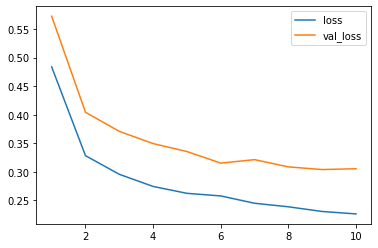

In [64]:
y_pred = nn.predict(X_val)

accuracy = accuracy_score(y_pred, y_val)
print("正答率:{}".format(accuracy))

x = np.arange(1, len(nn.list_train_loss)+1)
plt.plot(x, nn.list_train_loss, label="loss")
plt.plot(x, nn.list_test_loss, label="val_loss")
plt.legend()
plt.show()

問題7のAlexNetチックなモデルより良い性能が出せた。

### 【問題7】（アドバンス課題）LeNet
CNNで画像認識を行う際は、フィルタサイズや層の数などを１から考えるのではなく、有名な構造を利用することが一般的です。現在では実用的に使われることはありませんが、歴史的に重要なのは1998年の LeNet です。この構造を再現してMNISTに対して動かし、Accuracyを計算してください。

[Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11):2278–2324, 1998.](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)

<img src="https://t.gyazo.com/teams/diveintocode/83358987a273743a589b9388dfdf59ac.png" width="400">

※上記論文から引用

サブサンプリングとは現在のプーリングに相当するものです。現代風に以下のように作ってみることにします。活性化関数も当時はシグモイド関数ですが、ReLUとします。

1. 畳み込み層　出力チャンネル数6、フィルタサイズ5×5、ストライド1
2. ReLU
3. 最大プーリング
4. 畳み込み層　出力チャンネル数16、フィルタサイズ5×5、ストライド1
5. ReLU
6. 最大プーリング
7. 平滑化
8. 全結合層　出力ノード数120
9. ReLU
10. 全結合層　出力ノード数84
11. ReLU
12. 全結合層　出力ノード数10
13. ソフトマックス関数

In [49]:
class ScratchDeepNeuralNetrowkClassifier():
    def __init__(self, lr, verbose=True, batch_size=20, max_iter=3):
        self.verbose = verbose
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.list_train_loss = []
        self.list_test_loss = []
        # レイヤの生成
        initializer = XavierInitializer()
        initializer_conv = XavierInitializer_conv()
        optimizer = AdaGrad(lr=lr)
        self.layers = OrderedDict()
        filter_info_1 = (6, 1, 5, 5)
        filter_info_2 = (16, 6, 5, 5)
        pad = 0
        self.layers["Conv2d_1"] = Conv2d(filter_info_1, initializer_conv, optimizer, pad=pad, stride=1)
        self.layers["ReLU1"] = Relu()
        self.layers["Pooling1"] = MaxPool2D(2, 2, stride=2, pad=pad)
        self.layers["Conv2d_2"] = Conv2d(filter_info_2, initializer_conv, optimizer, pad=pad, stride=1)
        self.layers["ReLU2"] = Relu()
        self.layers["Pooling2"] = MaxPool2D(2, 2, stride=1, pad=pad)
        self.layers["Flatten"] = Flatten()
        self.layers["FC1"] = FC(784, 120, initializer, optimizer)
        self.layers["ReLU3"] = Relu()
        self.layers["FC2"] = FC(120, 84, initializer, optimizer)
        self.layers["ReLU4"] = Relu()
        self.layers["FC3"] = FC(84, 10, initializer, optimizer)
        self.lastLayer = Softmax()
    
    def fit(self, X, y, X_val=None, y_val=None):
        flg_test = 0
        if (X_val is not None) and (y_val is not None):
            flg_test = 1

        # 1エポックの繰り返し数
        iter_num = int(len(X) / self.batch_size)
            
        # エポックを複数回繰り返す
        for i_ in range(self.max_iter):
            # 損失計算用
            tmp_list_loss_train = []
            tmp_list_loss_val = []

            # 1エポック
            for j_ in range(iter_num):
                batch_mask = np.random.choice(X.shape[0], self.batch_size)
                batch_mask_val = np.random.choice(X_val.shape[0], self.batch_size)
                X_batch = X[batch_mask]
                y_batch = y[batch_mask]
                X_val_batch = X_val[batch_mask_val]
                y_val_batch = y_val[batch_mask_val]
                
                self._gradient(X_batch, y_batch)
                
                loss_train = self._loss(X_batch, y_batch)
                tmp_list_loss_train.append(loss_train)
                if flg_test == 1:
                    loss_test = self._loss(X_val_batch, y_val_batch)
                    tmp_list_loss_val.append(loss_test)
                    
                if self.verbose:
                    #verboseをTrueにした際は学習過程などを出力する
                    print("loss_train:{}".format(loss_train))
                    print("loss_test:{}".format(loss_test))
            
            # 損失をインスタンス領域に設定
            self.list_train_loss.append(sum(tmp_list_loss_train)/len(tmp_list_loss_train))
            self.list_test_loss.append(sum(tmp_list_loss_val)/len(tmp_list_loss_val))
                
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        for layer in self.layers.values():
            X = layer.forward(X)
            
        pred = np.argmax(X, axis=1)
        
        return pred
    
    def _loss(self, X, t):
        for layer in self.layers.values():
            X = layer.forward(X)
        
        return self.lastLayer.forward(X, t)

    def _gradient(self, X, t):
        self._loss(X, t)
        
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
                    
        return

In [50]:
nn = ScratchDeepNeuralNetrowkClassifier(lr=0.1, verbose=False, batch_size=20, max_iter=10)
nn.fit(X_train, y_train, X_val, y_val)

In [51]:
y_val = np.argmax(y_val, axis=1)

正答率:0.8858333333333334


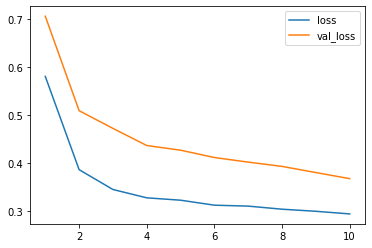

In [52]:
y_pred = nn.predict(X_val)

accuracy = accuracy_score(y_pred, y_val)
print("正答率:{}".format(accuracy))

x = np.arange(1, len(nn.list_train_loss)+1)
plt.plot(x, nn.list_train_loss, label="loss")
plt.plot(x, nn.list_test_loss, label="val_loss")
plt.legend()
plt.show()

### 【問題8】（アドバンス課題）有名な画像認識モデルの調査
CNNの代表的な構造としてははAlexNet(2012)、VGG16(2014)などがあります。こういったものはフレームワークで既に用意されていることも多いです。

どういったものがあるか簡単に調べてまとめてください。名前だけでも見ておくと良いでしょう。

《参考》
[Applications - Keras Documentation](https://keras.io/ja/applications/)

##### 【AlexNet】
問題7のLeNet再現モデルに加えて、DropoutやLRN(Local Response Normalization)を用いたモデル

##### 【VGG16】
[ImageNet](https://kotobank.jp/word/ImageNet-2119310)で事前学習した重みを利用可能なモデル。畳み込み13層、全結合層3層で計16層あるネットワーク。簡単な画像認識を試すなら良さそうなモデル。kerasライブラリのデフォルトのインプットサイズは224×224。

※ImageNetのデータセット自体は1枚の画像に対して１つだけのラベルを割り当てるようなアノテーションをしており、正しく画像認識出来ない場合もあるので注意する。[(参考)](https://qiita.com/omiita/items/e1e377f30f624ad705b2)

##### 【VGG19】
[ImageNet](https://kotobank.jp/word/ImageNet-2119310)で事前学習した重みを利用可能なモデル。畳み込み16層、全結合層3層で計16層あるネットワーク。VGG16と同様、オブジェクトの画像認識において高い性能がある。kerasライブラリのデフォルトのインプットサイズは224×224。

"《参考》"にあるモデルは全てImageNetのデータセットで事前学習したモデルになっている。

#### 【EfficientNet】[(論文)](https://arxiv.org/pdf/1905.11946.pdf)
2019年5月にGoogle Brainから発表されたモデル。MobileNetとResNetのスケールアップとNAS(Neural Architecture Search)[(参考記事)](https://qiita.com/cvusk/items/536862d57107b9c190e2)によって作られた。

年々、新しいモデルが論文とともにSoTA(State of The Art)として表れている。気になる分野について新しい論文が出ているかはアンテナを張っておきたい。

### 【問題9】出力サイズとパラメータ数の計算
CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。

また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。

以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。

1.

- 入力サイズ : 144×144, 3チャンネル
- フィルタサイズ : 3×3, 6チャンネル
- ストライド : 1
- パディング : なし

2.

- 入力サイズ : 60×60, 24チャンネル
- フィルタサイズ : 3×3, 48チャンネル
- ストライド　: 1
- パディング : なし

3.

- 入力サイズ : 20×20, 10チャンネル
- フィルタサイズ: 3×3, 20チャンネル
- ストライド : 2
- パディング : なし

＊最後の例は丁度良く畳み込みをすることができない場合です。フレームワークでは余ったピクセルを見ないという処理が行われることがあるので、その場合を考えて計算してください。端が欠けてしまうので、こういった設定は好ましくないという例です。

#### 回答

1.

- 出力サイズ：142×142, 6チャンネル
- パラメータ数：3×3×3×6 + 6 = 168

2.

- 出力サイズ：58×58, 48チャンネル
- パラメータ数：24×3×3×48 + 48 = 10416

3.

- 出力サイズ：9×9, 20チャンネル
- パラメータ数：10×3×3×20 + 20 = 1820

### 【問題10】（アドバンス課題）フィルタサイズに関する調査
畳み込み層にはフィルタサイズというハイパーパラメータがありますが、2次元畳み込み層において現在では3×3と1×1の使用が大半です。以下のそれぞれを調べたり、自分なりに考えて説明してください。

- 7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由
- 高さや幅方向を持たない1×1のフィルタの効果

#### 回答
- [参考記事1](https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363)
- [参考記事2](https://medium.com/lsc-psd/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%82%A8%E3%83%B3%E3%82%B8%E3%83%8B%E3%82%A2%E3%81%AA%E3%82%89%E7%AD%94%E3%81%88%E3%82%89%E3%82%8C%E3%81%A6%E5%BD%93%E7%84%B6%E3%81%AE4%E3%81%A4%E3%81%AE%E5%95%8F%E9%A1%8C-%E7%95%B3%E3%81%BF%E8%BE%BC%E3%81%BF%E5%B1%A4%E7%B7%A8-659809195d2)

#### 7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由
畳み込み層は、画像からの特徴抽出を目的とすることを念頭に置いておく。入力する画像次第ではあるが、大きいフィルタだとストライドを1に設定したとしても、きめ細やかに特徴を抽出できない場合が想定されると考える。

#### 高さや幅方向を持たない1×1のフィルタの効果
きめ細やかに特徴抽出を行うが、隣接する情報がない。そのため、得られた特徴は限定的で汎用性がないと思われる。一方、計算量(パラメータ数)が少なくなるため、処理時間の短縮やメモリ節約に貢献する。

## 記事を参考に書いたものですが、理解に間違いがあればご指摘をお願いいたします。